# Visualization of Electricity Consumption
** Challenge 2 **

by Christoph Stich

March 3, 2016

In [72]:
from sklearn import cluster

import datetime
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

## Exploring the data

In [73]:
# TODO Fix path
df = pd.read_csv("~/git/EnergyDataSimulationChallenge/challenge2/data/total_watt.csv", header=None, 
                 parse_dates=0, index_col=0, names=['datetime', 'consumption'])
df['date'] = df.index.date
df['time'] = df.index.time
df['weekday'] = df.index.weekday

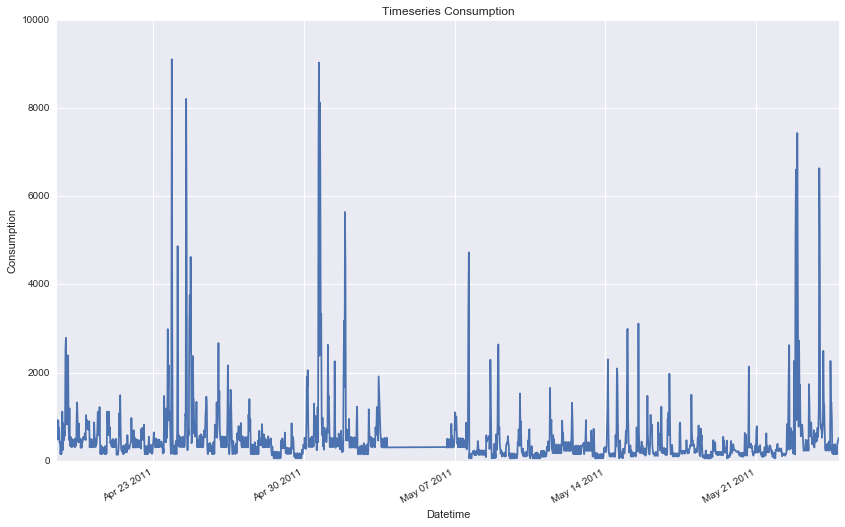

In [74]:
ax = df.plot(figsize=(14, 8.75), y='consumption', legend=False)
plt.title('Timeseries Consumption')
plt.xlabel('Datetime')
plt.ylabel('Consumption')

When looking at the time series of the electricity consumption, one can see that the data is rather 'spiky' and high values are rare.

/home/christoph/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


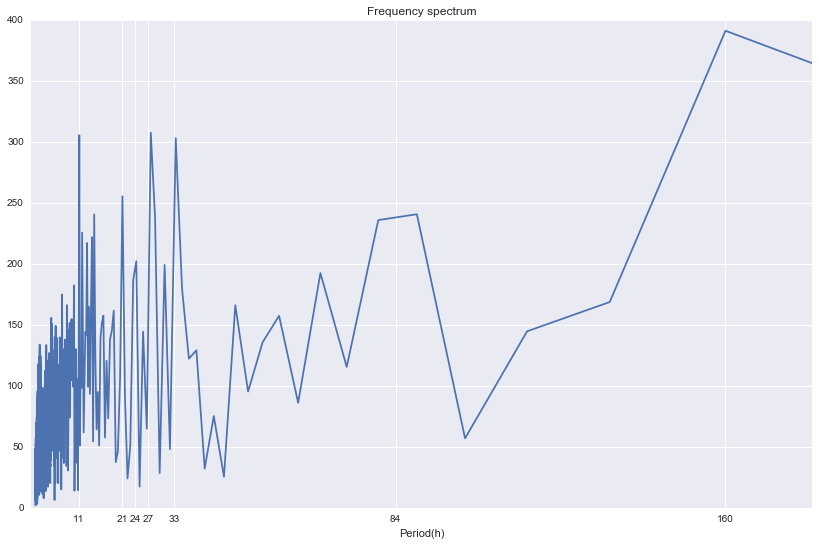

In [75]:
Y = np.fft.fft(df['consumption'])
N = len(Y)/2+1
fa = 1.0/(30.0*60.0) # every 15 minutes
X = np.linspace(0, fa/2, N, endpoint=True)
Xp = 1.0/X 
Xph= Xp/(60.0*60.0) 

fig, ax = plt.subplots(figsize=(14, 8.75))
plt.plot(Xph, 2.0*np.abs(Y[:N])/N)
plt.xticks([11, 21, 24, 27, 33, 84, 160])
plt.title('Frequency spectrum')
plt.xlim(0, 180)
plt.ylim(0, 400)
plt.xlabel('Period(h)')

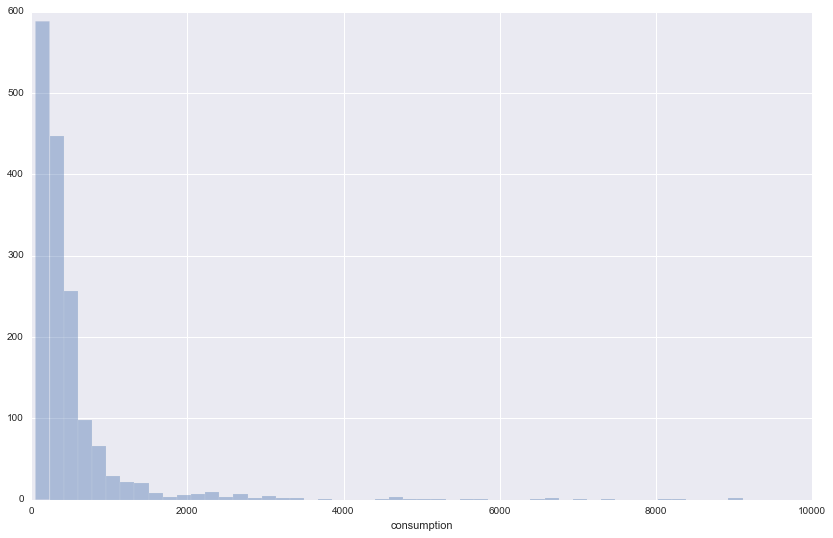

In [76]:
fig, ax = plt.subplots(figsize=(14, 8.75))
sns.distplot(df['consumption'], kde=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text xticklabel objects>)

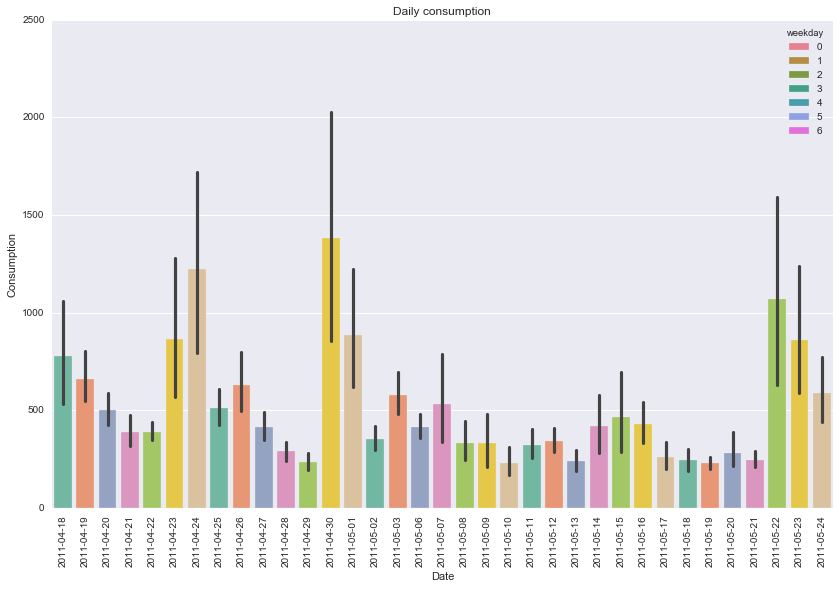

In [81]:
fig, ax = plt.subplots(figsize=(14, 8.75))
sns.barplot(x='date', y='consumption', data=df, hue='weekday', palette='husl', ci=None)
palette = itertools.cycle(sns.color_palette("Set2", 7))
sns.barplot(x='date', y='consumption', palette=palette, data=df)
plt.title('Daily consumption')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.xticks(rotation='vertical')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

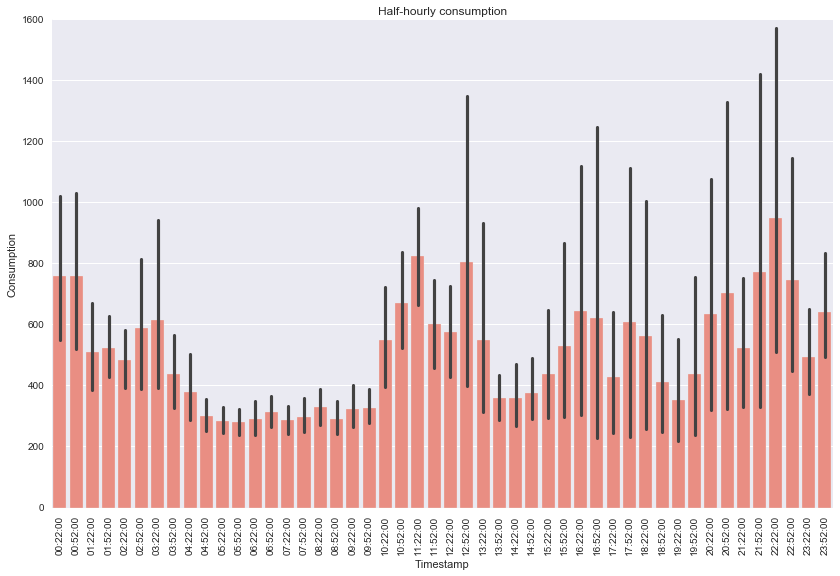

In [78]:
fig, ax = plt.subplots(figsize=(14, 8.75))
order = list(sorted(set(df['time'].values)))
sns.barplot(x='time', y='consumption', color='salmon', order=order, data=df)
plt.title('Half-hourly consumption')
plt.xlabel('Timestamp')
plt.ylabel('Consumption')
plt.xticks(rotation='vertical')

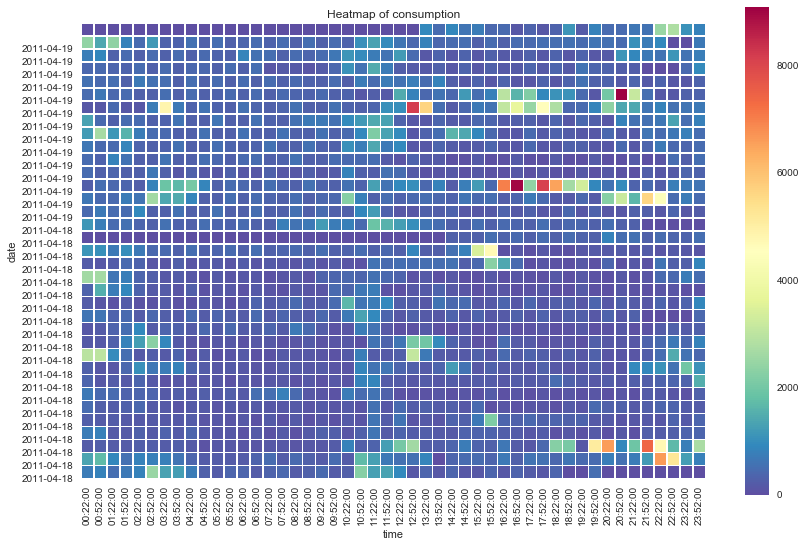

In [79]:
m = df.pivot(index='date', columns='time', values='consumption')
m = m.fillna(0.0)

fig, ax = plt.subplots(figsize=(14, 8.75))
sns.heatmap(m, square=True, cmap='Spectral_r', linewidths=.5)
yticks = [str(label)[:10] for label in df.index.values]
plt.yticks(range(34), yticks)
plt.title('Heatmap of consumption')

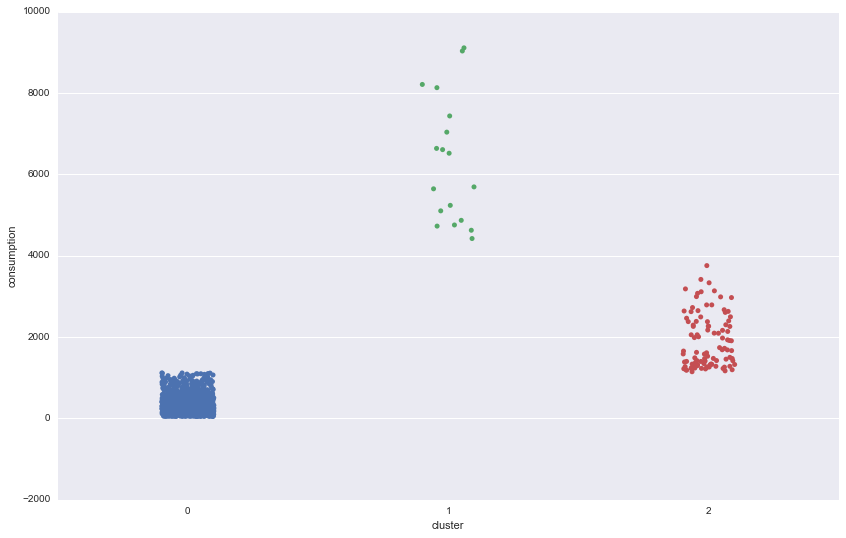

In [80]:
kmeans = cluster.KMeans(n_clusters=3, n_init=500)
kmeans.fit(np.asarray(df['consumption']).reshape(-1, 1))
df['cluster'] = kmeans.labels_

fig, ax = plt.subplots(figsize=(14, 8.75))
sns.stripplot(y='consumption', x='cluster', data=df, jitter=True)